## improved cyclegan horse2zebra directml

- forked from LynnHo/CycleGAN-Tensorflow-2
- improvements for lower memory requirements:
    - channel attention mechanism [[paper]](https://arxiv.org/abs/1807.02758)
    - residual in residual architecture [[paper]](https://arxiv.org/abs/1505.04597)
    - subpixel convolution / pixelshuffle [[paper]](https://arxiv.org/abs/1609.05158)

In [1]:
!pip install tensorflow-gpu==2.10.0 tensorflow_addons oyaml scikit-image 'numpy<2' tqdm matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 24.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninsta

In [1]:
!git clone https://github.com/adam-blip/CycleGan-directml
%cd CycleGan-directml

Cloning into 'CycleGan-directml'...
remote: Enumerating objects: 2883, done.
remote: Counting objects: 100% (2680/2680), done.
remote: Compressing objects: 100% (2671/2671), done.
remote: Total 2883 (delta 14), reused 2670 (delta 7), pack-reused 203 (from 1)
Receiving objects: 100% (2883/2883), 115.31 MiB | 16.36 MiB/s, done.
Resolving deltas: 100% (98/98), done.
/content/CycleGan-directml


In [2]:
import functools

import imlib as im
import numpy as np
import pylib as py
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
import tf2lib as tl
import tf2gan as gan
import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

In [3]:
# ==============================================================================
# =                                   param                                    =
# ==============================================================================

args = type('obj', (object,), {
    'dataset' : 'horse2zebra',
    'datasets_dir' : 'datasets',
    'load_size' : 286, # load image to this size
    'crop_size' : 256, # then crop to this size
    'batch_size' : 8,
    'epochs' : 200,
    'lr' : 0.0001,
    'beta_1' : 0.05,
    'adversarial_loss_mode' : 'lsgan', #'gan', 'hinge_v1', 'hinge_v2', 'lsgan', 'wgan'
    'gradient_penalty_mode' : 'wgan-gp', #'none', 'dragan', 'wgan-gp'
    'gradient_penalty_weight' : 10.0,
    'cycle_loss_weight' : 10.0,
    'identity_loss_weight' : 0.0,
    'pool_size' : 50 # pool size to store fake samples

})

# output_dir
output_dir = py.join('output', args.dataset)
py.mkdir(output_dir)


In [4]:
# ==============================================================================
# =                                    data                                    =
# ==============================================================================

def make_dataset(img_paths, batch_size, load_size, crop_size, training, drop_remainder=True, shuffle=True, repeat=1):
    if training:
        @tf.function
        def _map_fn(img):  # preprocessing
            img = tf.image.random_flip_left_right(img)
            img = tf.image.resize(img, [load_size, load_size])
            img = tf.image.random_crop(img, [crop_size, crop_size, tf.shape(img)[-1]])
            img = tf.clip_by_value(img, 0, 255) / 255.0  # or img = tl.minmax_norm(img)
            img = img * 2 - 1
            return img
    else:
        @tf.function
        def _map_fn(img):  # preprocessing
            img = tf.image.resize(img, [crop_size, crop_size])  # or img = tf.image.resize(img, [load_size, load_size]); img = tl.center_crop(img, crop_size)
            img = tf.clip_by_value(img, 0, 255) / 255.0  # or img = tl.minmax_norm(img)
            img = img * 2 - 1
            return img

    return tl.disk_image_batch_dataset(img_paths,
                                       batch_size,
                                       drop_remainder=drop_remainder,
                                       map_fn=_map_fn,
                                       shuffle=shuffle,
                                       repeat=repeat)


def make_zip_dataset(A_img_paths, B_img_paths, batch_size, load_size, crop_size, training, shuffle=True, repeat=False):
    # zip two datasets aligned by the longer one
    if repeat:
        A_repeat = B_repeat = None  # cycle both
    else:
        if len(A_img_paths) >= len(B_img_paths):
            A_repeat = 1
            B_repeat = None  # cycle the shorter one
        else:
            A_repeat = None  # cycle the shorter one
            B_repeat = 1

    A_dataset = make_dataset(A_img_paths, batch_size, load_size, crop_size, training, drop_remainder=True, shuffle=shuffle, repeat=A_repeat)
    B_dataset = make_dataset(B_img_paths, batch_size, load_size, crop_size, training, drop_remainder=True, shuffle=shuffle, repeat=B_repeat)

    A_B_dataset = tf.data.Dataset.zip((A_dataset, B_dataset))
    len_dataset = max(len(A_img_paths), len(B_img_paths)) // batch_size

    return A_B_dataset, len_dataset


class ItemPool:

    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        self.items = []

    def __call__(self, in_items):
        # `in_items` should be a batch tensor

        if self.pool_size == 0:
            return in_items

        out_items = []
        for in_item in in_items:
            if len(self.items) < self.pool_size:
                self.items.append(in_item)
                out_items.append(in_item)
            else:
                if np.random.rand() > 0.5:
                    idx = np.random.randint(0, len(self.items))
                    out_item, self.items[idx] = self.items[idx], in_item
                    out_items.append(out_item)
                else:
                    out_items.append(in_item)
        return tf.stack(out_items, axis=0)


A_img_paths = py.glob(py.join(args.datasets_dir, args.dataset, 'trainA'), '*.jpg')
B_img_paths = py.glob(py.join(args.datasets_dir, args.dataset, 'trainB'), '*.jpg')
A_B_dataset, len_dataset = make_zip_dataset(A_img_paths, B_img_paths, args.batch_size, args.load_size, args.crop_size, training=True, repeat=False, )

A2B_pool = ItemPool(args.pool_size)
B2A_pool = ItemPool(args.pool_size)

A_img_paths_test = py.glob(py.join(args.datasets_dir, args.dataset, 'testA'), '*.jpg')
B_img_paths_test = py.glob(py.join(args.datasets_dir, args.dataset, 'testB'), '*.jpg')
A_B_dataset_test, _ = make_zip_dataset(A_img_paths_test, B_img_paths_test, args.batch_size, args.load_size, args.crop_size, training=False, repeat=True)


In [5]:
def fast_normalization(x): # use clipping instead of batchnormalization for network stabilization
    return Lambda(lambda x: K.clip(x, -1, 1), output_shape=lambda s: (s[0], s[1], s[2], s[3]))(x)


def downsample_block(inputs): # squeeze
    x = inputs
    x = Conv2D(8, kernel_size = 9, activation = 'tanh', padding = 'same', strides = 2)(x)
    x = Conv2D(32, kernel_size = 9, activation = 'tanh', padding = 'same')(x)
    x = fast_normalization(x)
    x1 = x
    x = GlobalAveragePooling2D()(x)
    x = Dense(8, activation = 'relu')(x)
    x = Dense(32, activation = 'hard_sigmoid')(x)
    x = Reshape((1, 1, 32))(x)
    x = Multiply()([x1, x])

    x = Conv2D(32, kernel_size = 3, activation = 'tanh', padding = 'same', strides = 2)(x)
    x = Conv2D(128, kernel_size = 3, activation = 'tanh', padding = 'same')(x)
    x = fast_normalization(x)
    x2 = x
    x = GlobalAveragePooling2D()(x)
    x = Dense(32, activation = 'relu')(x)
    x = Dense(128, activation = 'hard_sigmoid')(x)
    x = Reshape((1, 1, 128))(x)
    x = Multiply()([x2, x])

    x = Conv2D(128, kernel_size = 1, activation = 'tanh', padding = 'same', strides = 2)(x)
    x = Conv2D(512, kernel_size = 1, activation = 'tanh', padding = 'same')(x)
    x = fast_normalization(x)
    x3 = x
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dense(512, activation = 'hard_sigmoid')(x)
    x = Reshape((1, 1, 512))(x)
    x = Multiply()([x3, x])
    return x

def combined_block(inputs): # pixelshuffle and squeeze
    x = skip1 = inputs
    x = Conv2D(8, kernel_size = 9, activation = 'tanh', padding = 'same', strides = 2)(x)
    x = Conv2D(32, kernel_size = 9, activation = 'tanh', padding = 'same')(x)
    x = fast_normalization(x)
    x1 = x
    x = GlobalAveragePooling2D()(x)
    x = Dense(8, activation = 'relu')(x)
    x = Dense(32, activation = 'hard_sigmoid')(x)
    x = Reshape((1, 1, 32))(x)
    x = skip2 = Multiply()([x1, x])

    x = Conv2D(32, kernel_size = 3, activation = 'tanh', padding = 'same', strides = 2)(x)
    x = Conv2D(128, kernel_size = 3, activation = 'tanh', padding = 'same')(x)
    x = fast_normalization(x)
    x2 = x
    x = GlobalAveragePooling2D()(x)
    x = Dense(32, activation = 'relu')(x)
    x = Dense(128, activation = 'hard_sigmoid')(x)
    x = Reshape((1, 1, 128))(x)
    x = skip3 = Multiply()([x2, x])

    x = Conv2D(128, kernel_size = 1, activation = 'tanh', padding = 'same', strides = 2)(x)
    x = Conv2D(512, kernel_size = 1, activation = 'tanh', padding = 'same')(x)
    x = fast_normalization(x)
    x3 = x
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dense(512, activation = 'hard_sigmoid')(x)
    x = Reshape((1, 1, 512))(x)
    x = Multiply()([x3, x])

    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2], 128, 2, 2)), output_shape = lambda s: (s[0], s[1], s[2], s[3] // 4, 2, 2))(x)
    x = Permute((3, 2, 4, 1, 5))(x)
    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2] * K.shape(x)[3], K.shape(x)[4] * K.shape(x)[5])), output_shape = lambda s: (s[0], s[1], s[2] * s[3], s[4] * s[5]))(x)
    x = Permute((3, 2, 1))(x)
    x = Add()([x, skip3])

    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2], 32, 2, 2)), output_shape = lambda s: (s[0], s[1], s[2], s[3] // 4, 2, 2))(x)
    x = Permute((3, 2, 4, 1, 5))(x)
    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2] * K.shape(x)[3], K.shape(x)[4] * K.shape(x)[5])), output_shape = lambda s: (s[0], s[1], s[2] * s[3], s[4] * s[5]))(x)
    x = Permute((3, 2, 1))(x)
    x = Add()([x, skip2])

    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2], 8, 2, 2)), output_shape = lambda s: (s[0], s[1], s[2], s[3] // 4, 2, 2))(x)
    x = Permute((3, 2, 4, 1, 5))(x)
    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2] * K.shape(x)[3], K.shape(x)[4] * K.shape(x)[5])), output_shape = lambda s: (s[0], s[1], s[2] * s[3], s[4] * s[5]))(x)
    x = Permute((3, 2, 1))(x)
    x = Add()([x, skip1])
    return x


x = inputs = Input(shape = (args.crop_size, args.crop_size, 3))
x = skip = Conv2D(8, kernel_size = 3, padding = 'same', activation = 'tanh')(x)
y = downsample_block(x)
x = combined_block(x)
x = Add()([skip, x])
x = Conv2D(3, kernel_size = 3, padding = 'same', activation = 'tanh')(x)
x = fast_normalization(x)

y = Conv2D(3, kernel_size = 3, padding = 'same', activation = 'tanh')(y)
y = fast_normalization(y)


In [6]:
# ==============================================================================
# =                                   models                                   =
# ==============================================================================

G_A2B = Model(inputs = inputs, outputs = x)
G_B2A = Model(inputs = inputs, outputs = x)

D_A = Model(inputs = inputs, outputs = y)
D_B = Model(inputs = inputs, outputs = y)

d_loss_fn, g_loss_fn = gan.get_adversarial_losses_fn(args.adversarial_loss_mode)
cycle_loss_fn = keras.losses.MeanAbsoluteError()
identity_loss_fn = keras.losses.MeanAbsoluteError()

G_optimizer = keras.optimizers.Adam(learning_rate=args.lr, beta_1=args.beta_1)
D_optimizer = keras.optimizers.Adam(learning_rate=args.lr, beta_1=args.beta_1)

In [7]:
# ==============================================================================
# =                                 train step                                 =
# ==============================================================================

@tf.function
def train_G(A, B):
    with tf.GradientTape() as t:
        A2B = G_A2B(A, training=True)
        B2A = G_B2A(B, training=True)
        A2B2A = G_B2A(A2B, training=True)
        B2A2B = G_A2B(B2A, training=True)
        A2A = G_B2A(A, training=True)
        B2B = G_A2B(B, training=True)

        A2B_d_logits = D_B(A2B, training=True)
        B2A_d_logits = D_A(B2A, training=True)

        A2B_g_loss = g_loss_fn(A2B_d_logits)
        B2A_g_loss = g_loss_fn(B2A_d_logits)
        A2B2A_cycle_loss = cycle_loss_fn(A, A2B2A)
        B2A2B_cycle_loss = cycle_loss_fn(B, B2A2B)
        A2A_id_loss = identity_loss_fn(A, A2A)
        B2B_id_loss = identity_loss_fn(B, B2B)

        G_loss = (A2B_g_loss + B2A_g_loss) + (A2B2A_cycle_loss + B2A2B_cycle_loss) * args.cycle_loss_weight + (A2A_id_loss + B2B_id_loss) * args.identity_loss_weight

    G_grad = t.gradient(G_loss, G_A2B.trainable_variables + G_B2A.trainable_variables)
    G_optimizer.apply_gradients(zip(G_grad, G_A2B.trainable_variables + G_B2A.trainable_variables))

    return A2B, B2A, {'A2B_g_loss': A2B_g_loss,
                      'B2A_g_loss': B2A_g_loss,
                      'A2B2A_cycle_loss': A2B2A_cycle_loss,
                      'B2A2B_cycle_loss': B2A2B_cycle_loss,
                      'A2A_id_loss': A2A_id_loss,
                      'B2B_id_loss': B2B_id_loss}


@tf.function
def train_D(A, B, A2B, B2A):
    with tf.GradientTape() as t:
        A_d_logits = D_A(A, training=True)
        B2A_d_logits = D_A(B2A, training=True)
        B_d_logits = D_B(B, training=True)
        A2B_d_logits = D_B(A2B, training=True)

        A_d_loss, B2A_d_loss = d_loss_fn(A_d_logits, B2A_d_logits)
        B_d_loss, A2B_d_loss = d_loss_fn(B_d_logits, A2B_d_logits)
        D_A_gp = gan.gradient_penalty(functools.partial(D_A, training=True), A, B2A, mode=args.gradient_penalty_mode)
        D_B_gp = gan.gradient_penalty(functools.partial(D_B, training=True), B, A2B, mode=args.gradient_penalty_mode)

        D_loss = (A_d_loss + B2A_d_loss) + (B_d_loss + A2B_d_loss) + (D_A_gp + D_B_gp) * args.gradient_penalty_weight

    D_grad = t.gradient(D_loss, D_A.trainable_variables + D_B.trainable_variables)
    D_optimizer.apply_gradients(zip(D_grad, D_A.trainable_variables + D_B.trainable_variables))

    return {'A_d_loss': A_d_loss + B2A_d_loss,
            'B_d_loss': B_d_loss + A2B_d_loss,
            'D_A_gp': D_A_gp,
            'D_B_gp': D_B_gp}


def train_step(A, B):
    A2B, B2A, G_loss_dict = train_G(A, B)

    # cannot autograph `A2B_pool`
    A2B = A2B_pool(A2B)  # or A2B = A2B_pool(A2B.numpy()), but it is much slower
    B2A = B2A_pool(B2A)  # because of the communication between CPU and GPU

    D_loss_dict = train_D(A, B, A2B, B2A)

    return G_loss_dict, D_loss_dict


@tf.function
def sample(A, B):
    A2B = G_A2B(A, training=False)
    B2A = G_B2A(B, training=False)
    A2B2A = G_B2A(A2B, training=False)
    B2A2B = G_A2B(B2A, training=False)
    return A2B, B2A, A2B2A, B2A2B


In [8]:
# ==============================================================================
# =                                 function for image visualization           =
# ==============================================================================

def show(image):
    image = (image + 1) * .5
    imgplot = plt.imshow(image)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    plt.show()


Epoch: 0
Loss:
A2Bg: 0.84271145 - B2Ag: 0.8460635 - A2B2Ac: 0.16448449 - B2A2Bc: 0.20960148
Ad: 0.85065174 - Bd: 0.8494113 - DAgp: 0.0021745928 - BBgp: 0.0021690251


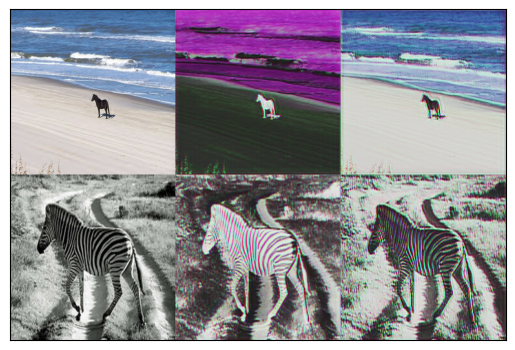


Epoch Loop:   0%|          | 0/200 [36:19<?, ?it/s]


KeyboardInterrupt: 

In [9]:
# ==============================================================================
# =                                    run                                     =
# ==============================================================================

# epoch counter
ep_cnt = tf.Variable(initial_value=0, trainable=False, dtype=tf.int64)

# checkpoint
checkpoint = tl.Checkpoint(dict(G_A2B=G_A2B,
                                G_B2A=G_B2A,
                                D_A=D_A,
                                D_B=D_B,
                                G_optimizer=G_optimizer,
                                D_optimizer=D_optimizer,
                                ep_cnt=ep_cnt),
                           py.join(output_dir, 'checkpoints'),
                           max_to_keep=5)
try:  # restore checkpoint including the epoch counter
    checkpoint.restore().assert_existing_objects_matched()
    print('checkpoint loaded...')
except Exception as e:
    print(e)

# summary
train_summary_writer = tf.summary.create_file_writer(py.join(output_dir, 'summaries', 'train'))

# sample
test_iter = iter(A_B_dataset_test)
sample_dir = py.join(output_dir, 'samples_training')
py.mkdir(sample_dir)

# main loop
with train_summary_writer.as_default():
    for ep in tqdm.trange(args.epochs, desc='Epoch Loop'):
        if ep < ep_cnt:
            continue

        # update epoch counter
        ep_cnt.assign_add(1)

        # train for an epoch
        for A, B in tqdm.tqdm(A_B_dataset, desc='Step', total=len_dataset):
            G_loss_dict, D_loss_dict = train_step(A, B)

            # # summary
            tl.summary(G_loss_dict, step=G_optimizer.iterations, name='G_losses')
            tl.summary(D_loss_dict, step=G_optimizer.iterations, name='D_losses')
            # sample
            if G_optimizer.iterations.numpy() % 1 == 0:
                clear_output()
                A, B = next(test_iter)
                A = A[0, :, :, :]
                A = A[np.newaxis, :]
                B = B[0, :, :, :]
                B = B[np.newaxis, :]
                A2B, B2A, A2B2A, B2A2B = sample(A, B)
                print('Epoch: ' + str(ep))
                print('Loss:')
                print(
                    'A2Bg: ' + str(G_loss_dict['A2B_g_loss'].numpy()) +
                    ' - B2Ag: ' + str(G_loss_dict['B2A_g_loss'].numpy()) +
                    ' - A2B2Ac: ' + str(G_loss_dict['A2B2A_cycle_loss'].numpy()) +
                    ' - B2A2Bc: ' + str(G_loss_dict['B2A2B_cycle_loss'].numpy())
                )
                print(
                    'Ad: ' + str(D_loss_dict['A_d_loss'].numpy()) +
                    ' - Bd: ' + str(D_loss_dict['B_d_loss'].numpy()) +
                    ' - DAgp: ' + str(D_loss_dict['D_A_gp'].numpy()) +
                    ' - BBgp: ' + str(D_loss_dict['D_B_gp'].numpy())
                )
                img = im.immerge(np.concatenate([A, A2B, A2B2A, B, B2A, B2A2B], axis=0), n_rows=2)
                show(img)


                # save checkpoint
                checkpoint.save(ep)
